<a href="https://colab.research.google.com/github/pantelis/DLTFpT/blob/master/notebooks/measuring_speed_of_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Measuring Learning in Intermediate Layers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In this notebook, we take a simple fully connected model for classifying MNIST digits and we examine the speed of learning at various hidden layers within the model.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pantelis/DLTFpT/blob/master/notebooks/measuring_speed_of_learning.ipynb)

#### Set seed for reproducibility

In [3]:
import numpy as np
np.random.seed(42)

#### Load dependencies

In [4]:
import tensorflow
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout # new!
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
%matplotlib inline

#### Define a custom callback

This callback grabs the weights at the end of each epoch and converts them back to gradients. The gradients are saved in a dictionary and at the end of training the Euclidean norm is taken as a measure of how fast training is moving in any given layer during any given epoch.

In [5]:
class GradHistory(tensorflow.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        # Initialize list of hidden layers
        self.layers = [layer for layer in self.model.layers if 'hidden_' in layer.name]
        
        # Initialize grads dict with empty list
        self.grads = {layer.name:[] for layer in self.layers}
        
        # Grab the initial weights from the model
        self.prev_w = [layer.get_weights()[0] for layer in self.layers]

    def on_epoch_end(self, batch, logs={}):
        # Get the weights at the end of the epoch
        curr_w = [layer.get_weights()[0] for layer in self.layers]
        
        # Get the LR at the end of the epoch
        lr = K.get_value(self.model.optimizer.lr)
        
        # Convert the previous and currents weights to gradients
        grads_ = [(prev - curr) for curr, prev in zip(curr_w, self.prev_w)]
        
        # Move the grads into the self.grads dict
        for i,layer in enumerate(grads_):
            self.grads[self.layers[i].name].append(layer)
        self.prev_w = curr_w
    
    def on_train_end(self, logs={}):
        # At the end of training, take the euclidean norm of each array of gradients in each layer at each epoch.
        self.norms = {k:[np.sqrt(np.sum([x*x for x in epoch])) for epoch in v] for k,v in self.grads.items()}

#### Load data

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


#### Preprocess data

In [7]:
X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')

In [8]:
X_train /= 255
X_test /= 255

In [9]:
n_classes = 10
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

#### Design neural network architecture

This function builds and returns a model.

In [15]:

from tensorflow.keras import layers
from tensorflow.keras import initializers

w_init = initializers.RandomNormal(stddev=0.1)
# w_init = initializers.glorot_normal()
# w_init = initializers.glorot_uniform()

def build_model(hidden = 2):
    
    model = Sequential()

    model.add(Dense(30, activation='sigmoid', input_shape=(784,),name='input', \
                    kernel_initializer=w_init, \
                    bias_initializer=initializers.Zeros()))
    
    for h in range(hidden):
        model.add(Dense(30, activation='sigmoid',name='hidden_{}'.format(h), \
                    kernel_initializer=w_init, \
                    bias_initializer=initializers.Zeros()))
    
    model.add(Dense(10, activation='softmax', \
                    kernel_initializer=w_init, \
                    bias_initializer=initializers.Zeros()))
    
    return model

#### Build, compile and train model

Here we actually call the `build_model()` function, compile the model, and return the history object (where the gradients will besaved after training).

In [16]:
def build_and_train(hidden = 1, epochs=200):
    
    model = build_model(hidden)
    history = GradHistory()
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    model.fit(X_train[:1000], y_train[:1000], batch_size=1, epochs=epochs, verbose=0, callbacks=[history])
    
    return history


`history.grads.norms` is a dict, with keys for each of the layers in the model. Each key contains a list of gradient norm values for that layer over all the epochs in training.

In [17]:
# Call the method to build and train the model, returning the history object
# Note, here we use five hidden layers and 200 epochs
norms_5 = build_and_train(5, 200)

#### Define a plotting function

In [18]:
def plot(history, hidden, log=False):   
    fig = plt.figure(figsize=(8,6),dpi=300)
    
    layers = [layer for layer in history.norms.keys()]
    values = [history.norms[layer] for layer in layers]
    
    for layer,values in zip(layers[::-1],values[::-1]):
        ys = np.array(values[:])
        xs = np.array(range(ys.shape[0]))
        ys_smooth = gaussian_filter1d(ys, sigma=3)
        plt.plot(xs, ys_smooth, label=layer)
        
    plt.title('Learning speed with {} hidden layers'.format(hidden))
    plt.ylabel('Learning speed')
    if log:
        plt.yscale('log')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

#### Plot the results

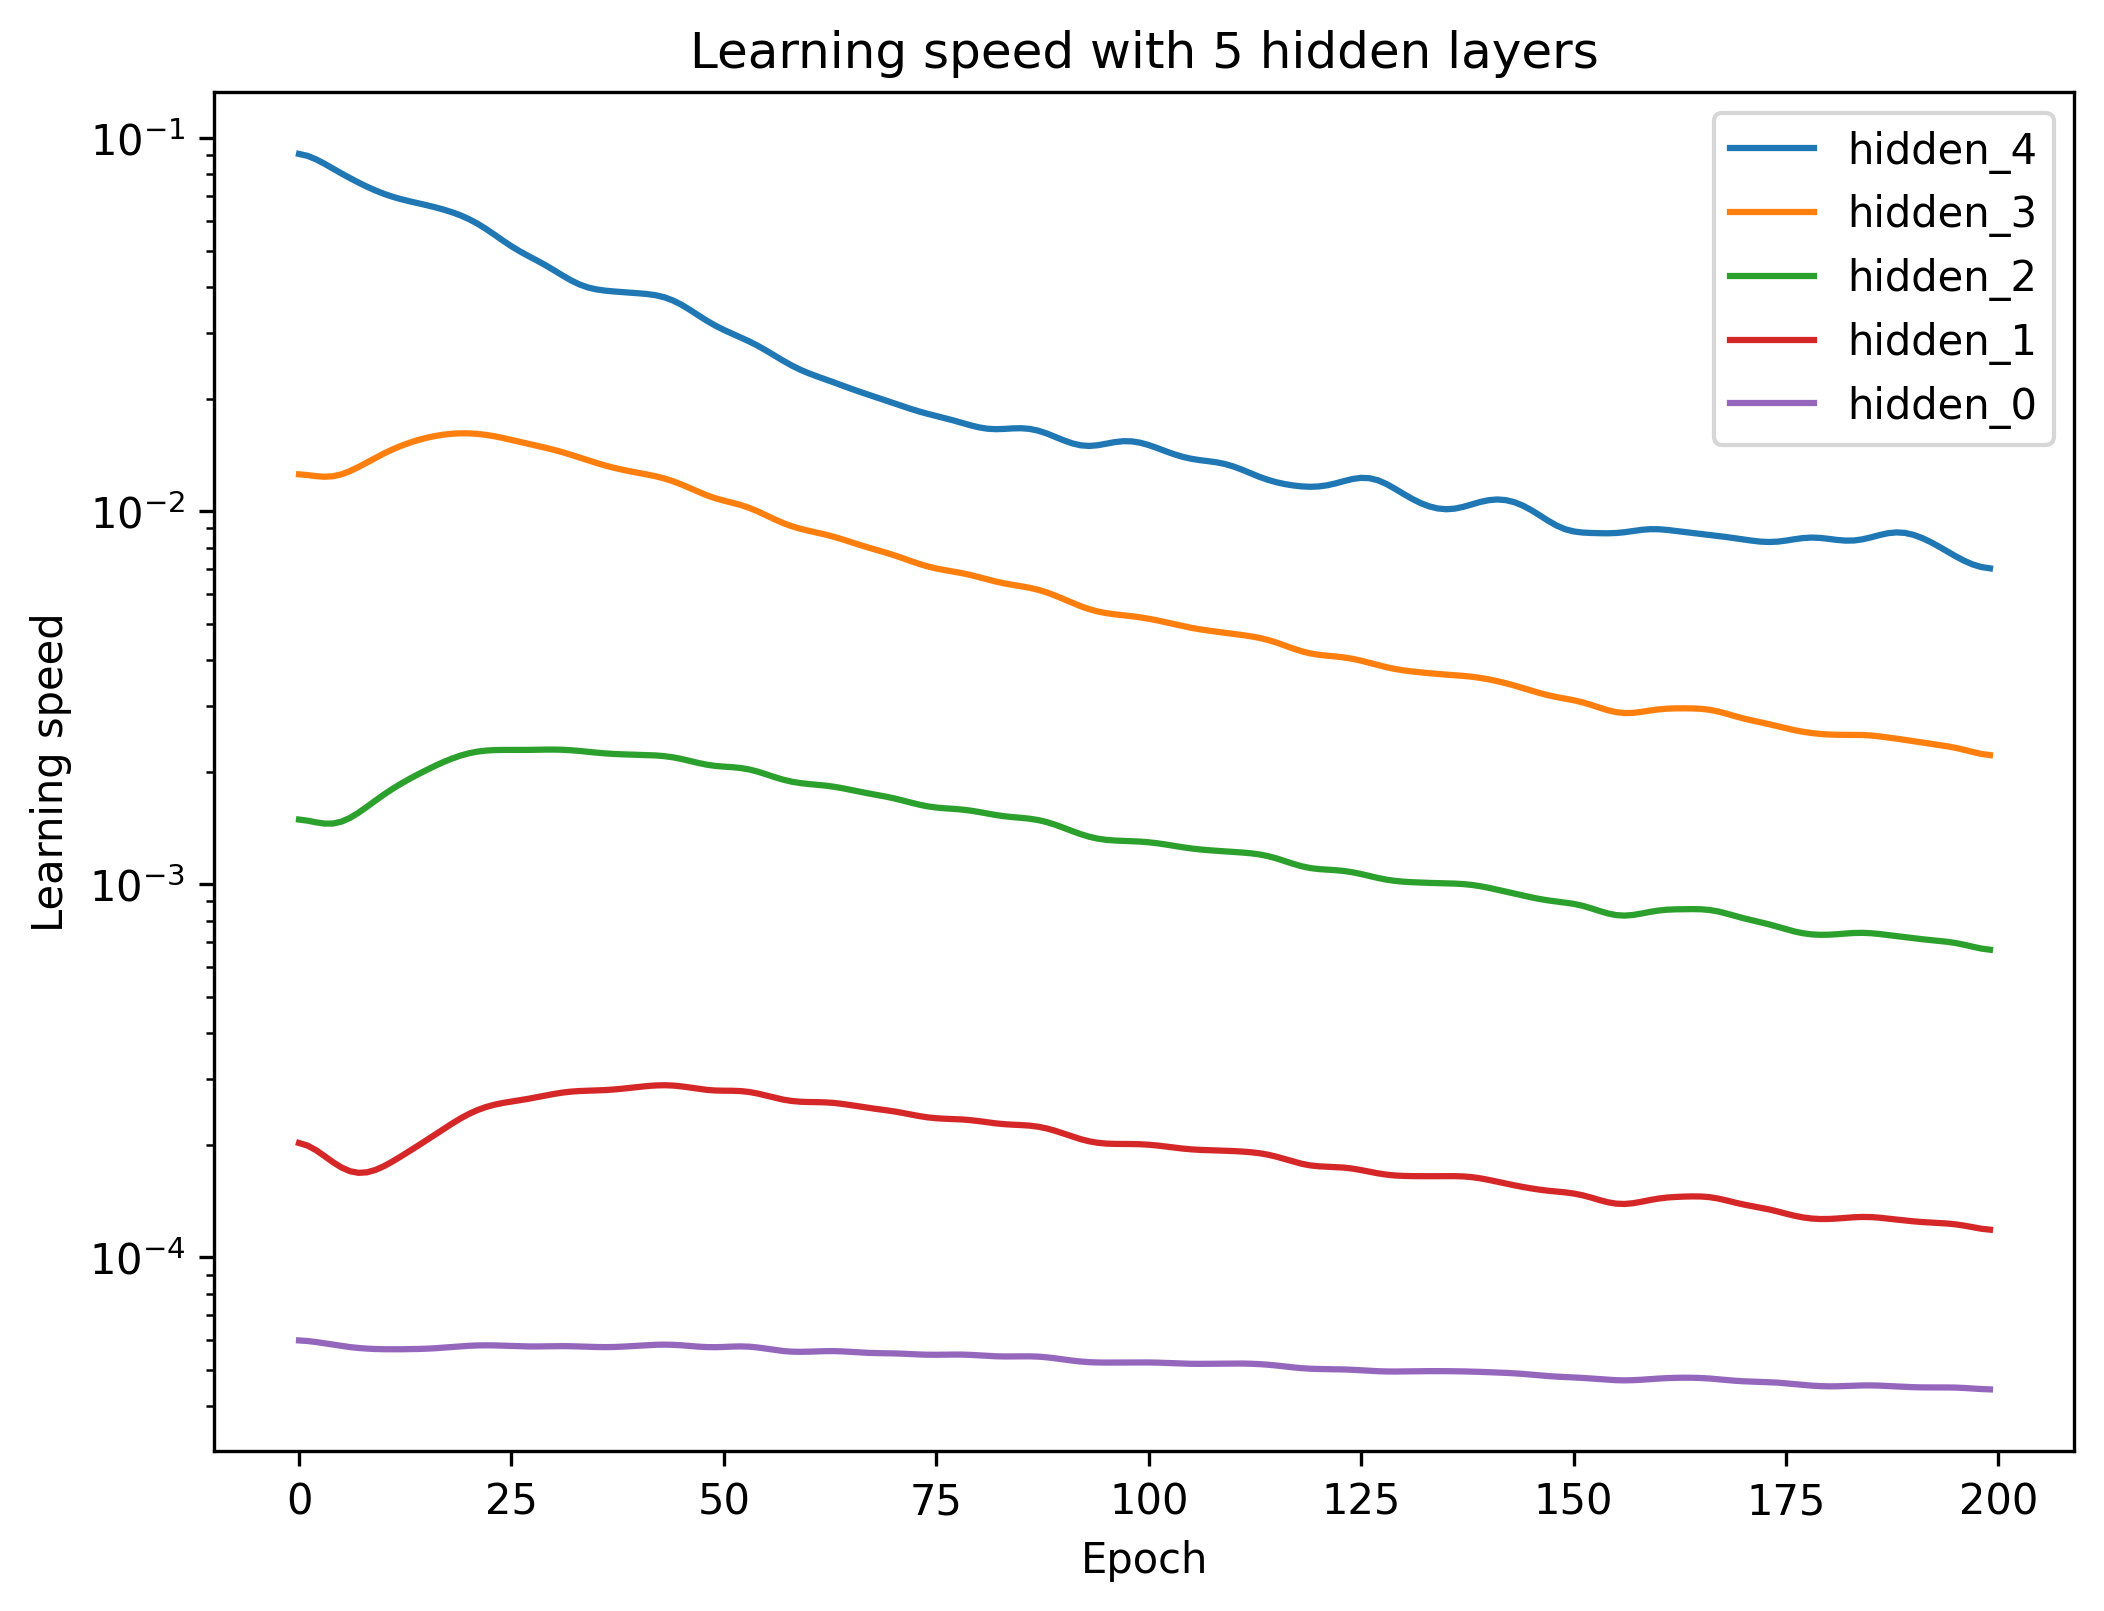

In [19]:
plot(norms_5, 5, True)